# French Electric Mix in 2019

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sn 
%matplotlib inline 
plt.style.use('ggplot')

* https://opendata.reseaux-energies.fr/pages/accueil/
* https://bilan-electrique-2019.rte-france.com/
* https://transparency.entsoe.eu/

# Module construction production & demande 

> Données entrée : 
* Courbe de demande 
* Courbe de production 
* Capacité installée de chaque filière
* Demande nette fournit imports/exports





# Reconstruire la courbe 

In [2]:
hours = [i for i in range(24)]

demande = [50,45,40,40,40,40,40,40,40,45,50,55,60,60,60,70,70,70,65,60,57,53,50,50]
capacity = [30,20,10,5]

calculer ce qu'il faut combler, prendre à chaque heure, division euclidienne de la valeur


In [3]:
def dispatch(demande, capacity):
    capacity.sort(reverse=True)
    # Il faut d'abord créer le dispatch, pour cela on utilise une matrice afin de savoir quelle unité sont utilisée à quelle heure
    mat = np.zeros((len(capacity)+1,24))
    capacities = np.zeros((len(capacity)+1,24))
    for (i,d) in enumerate(demande) : 
        # Pour chaque demande horaire, nous devons calculer le dispatch adéquat
        r = d 
        j = 0
        while r!=0 and j<len(capacity) :
                if capacity[j] < r:
                    # Cette capacité n'est pas suffisante pour répondre à la demande
                    r = r-capacity[j]
                    mat[j][i] = 1
                else :
                    # La capacité  est supérieure à ce dont nous avons besoin on n'en utilisera qu'une partie 
                    r = 0
                    mat[j][i] = 1
                    # signifie que nous allons exporter l'énergie résiduelle 
                    mat[len(capacity)][i] = -1

                j+=1
        if r!=0:
            mat[len(capacity)][i] = 1
    #Ensuite on créé les vecteurs qui vont nous permettre d'afficher le dispatch
    for i in range(len(hours)):
        #### On parcourt chaque heure
        maxcap_h = 0 #Permet de savoir quelle est le niveau minimum de production pour chaque heure utile pour tracer
        for j in range(len(capacity)+1):
            if j!=len(capacity):
                if mat[j][i] !=0:
                    capacities[j][i] = sum(capacity[:j+1]) #On définit la capacité
                    maxcap_h = capacities[j][i]
                else :
                    capacities[j][i] = maxcap_h

            else : 
                if mat[j][i]!=0:
                    # Les unités de production ne sont pas suffisante, ou trop importantes, il faut importer // exporter
                    capacities[j][i] = (demande[i]-sum(capacity))
    plot_dispatch(demande,capacity,capacities,mat)
    return(mat,capacities)

## Capacity to draw

In [11]:
def plot_dispatch(demande,capacity,capacities,mat):
    hours = np.array([i for i in range(24)])
    colors = ['orange',"gray",'blue','yellow','green']
    labels = ["Nucléaire","Thermique","Eolien","Solaire"]
    plt.figure(figsize=(10,10))
    plt.plot(hours,demande,label="Demande",linewidth = 7)
    plt.ylabel('kMW')
    plt.xlabel('Heures')

    for i in range(len(capacity)):
        if i ==0:
            plt.fill_between(hours,capacities[i][:],color=colors[i],label=labels[i])
        else : 
            plt.fill_between(hours,capacities[i-1][:],capacities[i][:],color=colors[i],label=labels[i])
    # Plot import & Export
    # Export
    imp_exp = capacities[len(capacity)-1][:]
    plt.fill_between(hours,imp_exp,demande,where = imp_exp>=demande,color='pink',label=f'Export')
    #Import 
    plt.fill_between(hours,imp_exp,demande,where = demande>=imp_exp, color='cyan',label=f'Import')
    plt.title(f'Dispatch avec {len(capacity)} outils de production')
    plt.legend(loc='upper left')

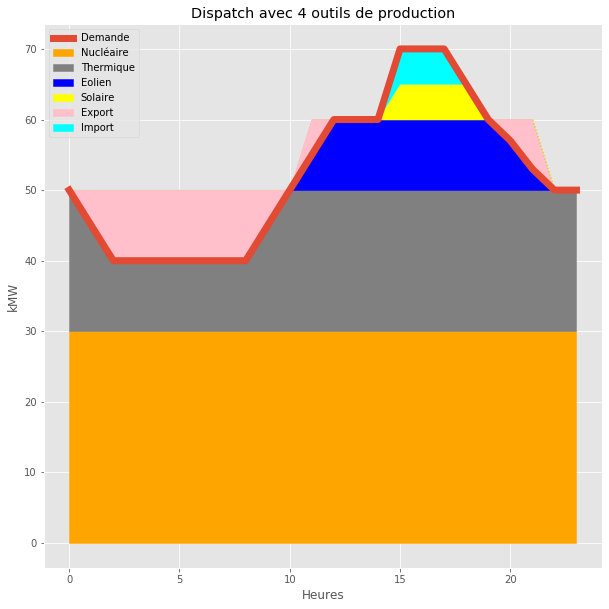

In [12]:
mat,capacities = dispatch(demande,capacity)

In [7]:
capacity2 = [25,20]

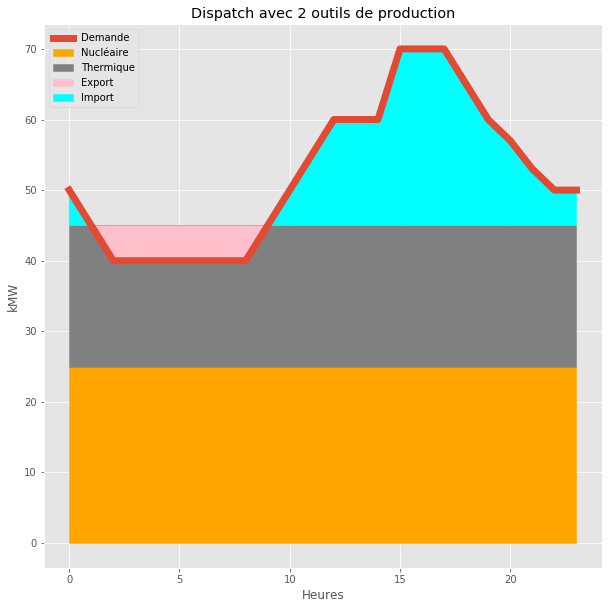

In [8]:
mat2,cap2 = dispatch(demande,capacity2)

## Read real data from 2020/01/01

### Consommation

In [41]:
conso = pd.read_excel('consommation-quotidienne-brute.xlsx')

In [42]:
conso["Date - Heure"] = pd.to_datetime(conso["Date - Heure"])

In [43]:
conso = conso[conso.Date=='01/01/2020']
conso = conso.sort_values(by='Date - Heure').reset_index(drop=True)


In [44]:
conso.head(2)

,Date - Heure,Date,Heure,Consommation brute électricité (MW) - RTE
0,2020-01-01 00:00:00+01:00,01/01/2020,00:00,67104
1,2020-01-01 00:30:00+01:00,01/01/2020,00:30,65916


### Production

In [45]:
prod = pd.read_excel('production-quotidienne-filiere.xlsx')

In [47]:
prod["Date - Heure"] = pd.to_datetime(prod["Date - Heure"])
prod = prod.sort_values(by='Date - Heure').reset_index(drop=True)

In [53]:
prod = prod.replace({-1:0}) #-1 quand pas de production -> 0 

In [69]:
col_prod = prod.columns[3:]

In [70]:
# Besoin de reorganiser le df

In [76]:
order_col = prod[col_prod].mean().sort_values(ascending=False).index
df = prod[order_col[1:]]

In [77]:
df.head()

,Production nucléaire (MW),Production hydraulique (MW),Production thermique fossile (MW),Production gaz (MW),Production éolienne (MW),Production bioénergies (MW),Production solaire (MW),Production fioul (MW),Production charbon (MW)
0,49227,9072,6885,6502,3716,1209,0,351,32
1,49437,9554,6722,6394,3571,1165,0,316,12
2,48970,9102,6284,5970,3144,1159,0,301,13
3,49648,9093,5663,5364,2924,1158,0,285,14
4,49764,8667,5368,5251,2739,1169,0,104,13


In [95]:
df.iloc[:,:1]

,Production nucléaire (MW)
0,49227
1,49437
2,48970
3,49648
4,49764
5,49747
6,49527
7,49887
8,49299
9,49714


In [97]:
cumul

[[], [], [], [], [], [], [], [], []]

In [108]:
cumul_df = pd.DataFrame()
cumul = [[]]*len(df.columns)
for i,col in enumerate(df.columns) : 
    cumul[i] = df.iloc[:,:i+1].cumsum(axis=1).iloc[:,i].values
    cumul_df[col] = cumul[i]

ConversionError: Failed to convert value(s) to axis units: 'Production éolienne (MW)'

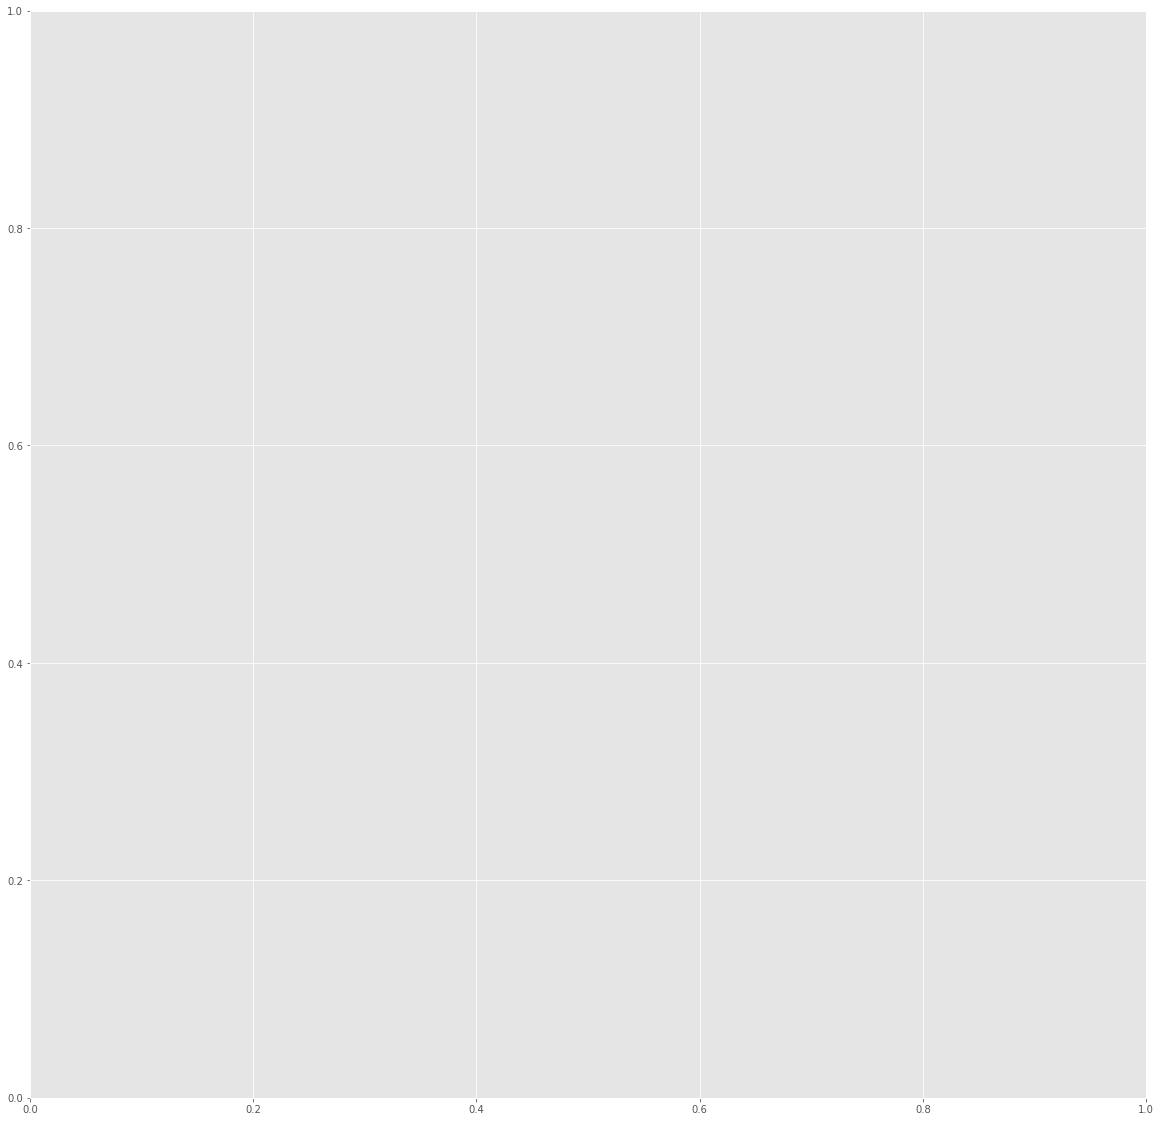

In [114]:
plt.figure(figsize=(20,20))
plt.xlim(0,max(cumul_df))
cumul_df.plot(figsize=(20,20))

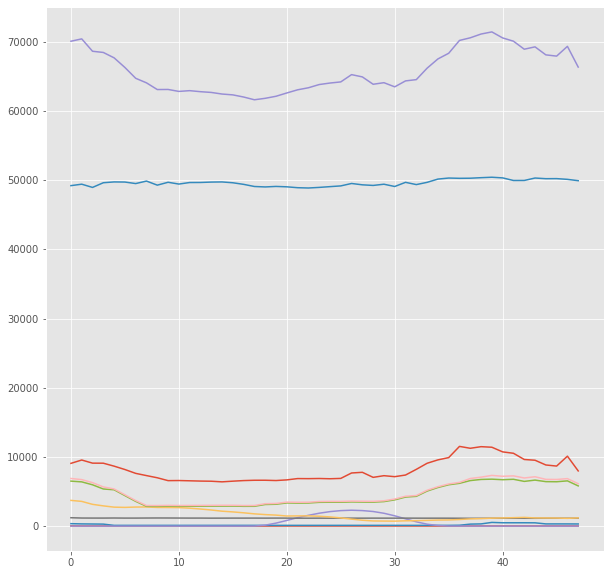

In [68]:
plt.figure(figsize=(10,10))
for col in df:
    plt.plot(df[col])

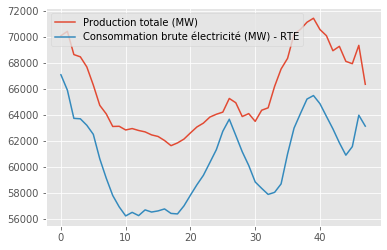

In [48]:
prod['Production totale (MW)'].plot()
conso['Consommation brute électricité (MW) - RTE'].plot()
plt.legend()

In [ ]:
prod['P']